# Example: Cylinder Flow - Part 3/3

- Author: Dr. Daning Huang
- Date: 10/11/2025

As the last part of the example, we show some modal analysis results of the previously learned model.  The results from linear models coincide with classical DMD analysis, while the nonlinear one show something different.

## Preparation

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as spl

from dymad.models import DKBF, KBF
from dymad.numerics import complex_plot
from dymad.sako import SpectralAnalysis
from dymad.utils import animate, load_model, plot_contour, plot_trajectory, setup_logging

Import data and estimate the base frequency.

In [18]:
Nx, Ny = 199, 449
dat = np.load('data/cylinder.npz')
t_grid = dat['t']
xs = dat['x']
dt = t_grid[1] - t_grid[0]

_tmp = xs - np.mean(xs, axis=0)
u, _, _ = spl.svd(_tmp, full_matrices=False)
_tmp = u[:,0] - np.mean(u[:,0])
sp = np.fft.fft(_tmp)
fr = np.fft.fftfreq(len(t_grid))/dt*(2*np.pi)
ii = np.argmax(np.abs(sp))
w0 = np.abs(fr[ii])
wc = np.array([-1,1]) * (1j*w0)
wa = np.exp(wc*dt)

Instantiate the four Koopman models from the previous part.  Here the `SpectralAnalysis` class, introduced in earlier examples, is used.

In [ ]:
sact = SpectralAnalysis(KBF,  'kp_kbf_node.pt', dt=dt, reps=1e-10, etol=1e-12, remove_one=False)
sand = SpectralAnalysis(DKBF, 'kp_dkbf_ln.pt',  dt=dt, reps=1e-10, etol=1e-12, remove_one=False)
saae = SpectralAnalysis(DKBF, 'kp_dkbf_ae.pt',  dt=dt, reps=1e-10, etol=1e-12, remove_one=False)
sadm = SpectralAnalysis(DKBF, 'kp_dkbf_dm.pt',  dt=dt, reps=1e-10, etol=1e-12, remove_one=False)

sas = [sact, sand, saae, sadm]
lbs = ['CT-ND', 'DT-LN', 'DT-AE', 'DT-DM']
Nsa = len(sas)

## Results

### Eigenvalues and pseudospectra

The plotting of eigenvalues and pseudospectra has been introduced before, and here we use it as sanity check.  All models give reasonable predictions:

- The continuous-time and discrete-time linear models (CT-ND and DT-LN) all produce 13 eigenvalues, which are approximately the integer multiples of the reference frequency.  There is a zero eigenvalue for the constant offset in the dynamics.
- The nonlinear models (DT-AE and DT-DM) obtains 3 eigenvalues as designed, and both capture the base frequency.  In DT-AE there is a spurious decaying mode, while in DT-DM the zero eigenvalue is due to a constant-valued embedding in Diffusion Map.
- In the pseudospectra, dotted lines are directly computed from the identified system matrix, while the solid lines are from the data-driven estimation.  The latter "carves out" the portion of pseudospectra that is relevant to data.

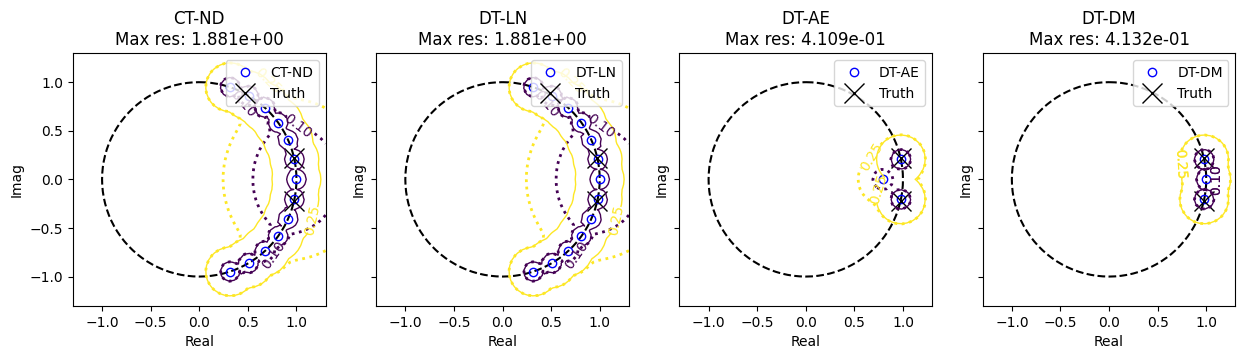

In [26]:
## Eigenvalues
MRK = 15
f, ax = plt.subplots(ncols=Nsa, sharey=True, figsize=(15,5))
for _i in range(Nsa):
    f, ax[_i], _ls = sas[_i].plot_eigs(fig=(f, ax[_i]), plot_filt=None)
    _l, = ax[_i].plot(wa.real, wa.imag, 'kx', markersize=MRK)
    ax[_i].set_title(f'{lbs[_i]}\nMax res: {sas[_i]._res[-1]:4.3e}')
    ax[_i].legend(_ls+[_l], [lbs[_i], "Truth"], loc=1)

# Pseudospectra
_x = np.linspace(-1.3, 1.3, 51)
gg = np.vstack([_x, _x])
rng = np.array([0.1, 0.25])

# Predicted
pss, psk = [], []
for _s in sas:
    grid, _pss = _s.estimate_ps(gg, mode='disc', method='standard', return_vec=False)
    grid, _psk = _s.estimate_ps(gg, mode='disc', method='sako', return_vec=False)
    pss.append((grid, _pss))
    psk.append((grid, _psk))

for _i in range(Nsa):
    grid, _pss = pss[_i]
    grid, _psk = psk[_i]
    f, ax[_i] = complex_plot(grid, 1/_pss, rng, fig=(f, ax[_i]), mode='line', lwid=2, lsty='dotted')
    f, ax[_i] = complex_plot(grid, 1/_psk, rng, fig=(f, ax[_i]), mode='line', lwid=1)

### Spatial modes

A typical product from DMD is the modes, that reveal coherent patterns in the spatiotemporal dynamics at individual frequencies.  `SpectralAnalysis` provides this functionality via `eval_eigmode_jac`, that evaluates the modes, and `plot_eigjac_contour`, that wraps the former and plot the modes.

> The notion of `jac` will be clear in the next section.

Below we plot the first 3 modes from the two linear models (CT-ND and DT-LN).  Since the modes are in conjugate pairs, we take every other modes, and plot the real and imaginary components - they look like the usual DMD modes.  We also plot the amplitude and phase of the modes as a reference.

- CT-ND and DT-LN differ slightly, because the conjugate pairs are equivalent up to rotation.
- In conventional CT-ND, one would compute $\dot{z}$ by finite difference and linear regress to find the system matrix.  This would not produce accurate modes and predictions.  Our approach uses NODE training to reduce trajectory error, and this is how we can obtain correct modes.

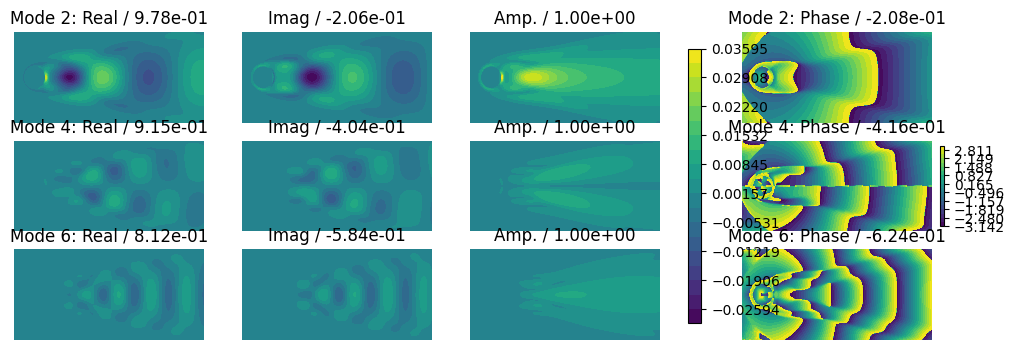

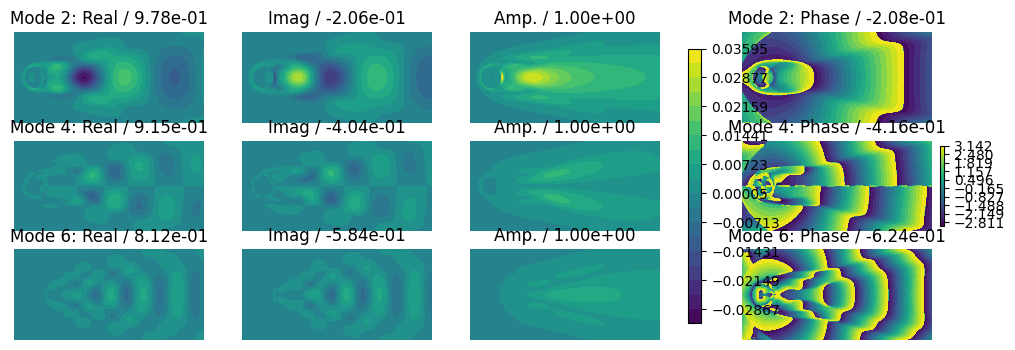

In [21]:
for i in range(2):
    f, ax = plt.subplots(nrows=3, ncols=4, figsize=(12,4))
    sas[i].plot_eigjac_contour(
        eig='mode',                   # Plot the eigenmodes
        lam='dt',                     # Show discrete-time eigenvalues
        comp='ria',                   # Show real, imag, amplitude components
        idx=[2,4,6],                  # Show Modes 2, 4, 6
        shape=(Nx, Ny),               # For reshaping into 2D arrays for contours
        contour_args={
            "axes":(f, ax[:,:3]),     # Plot results in the first 3 columns of axes
            "colorbar":True,
            "mode":'contourf'})
    sas[i].plot_eigjac_contour(       # Plotting phase separately due to different range
        eig='mode', lam='dt', comp='p',           # p for phase
        idx=[2,4,6], shape=(Nx, Ny),
        contour_args={
            "axes":(f, ax[:,3].reshape(-1,1)),    # Plot results in the last column of axes
            "colorbar":True, "mode":'contourf'})
    for _a in ax.flatten():
        _a.set_axis_off()

### Tangent modes

In the nonlinear models (DT-AE and DT-DM), the observations are transformed nonlinearly into the latent space:

- In DT-AE, the nonlinearity is the autoencoder, that is inside the trained model and learned during the training
- In DT-DM, the nonlinearity is the Diffusion Map, that is in the Data Transform stage and determined before training

Nevertheless, in `DyMAD` they are treated in a unified manner, and we extract the tangent modes that are equivalent to the usual modes when the transformation is linear.  The technical details are explained below, but one can skip for the first time reading.

**Technical details:** Write the model as

$$
z=\phi(x),\quad \dot{z}=Az,\quad x=\psi(z)
$$

with eigendecomposition $A=U\Lambda W^\top$, and $\phi$ and $\psi$ can involve the data transforms in preprocessing as well as the autoencoder.

The solution can be written as $z(t)=Uc(t)$; here $c(t)$ are time-varying modal coordinates that are determined by the initial conditions and eigenvalues.  In data space, the solution is $x(t)=\psi(Uc(t))$.

- If $\psi$ were linear, e.g., $\psi(x)=Qx$, then $x(t)=QUc(t)$, and the columns of $QU$, $q_i=Qu_i$, are the usual Koopman modes or DMD modes that evolve in time harmonically (i.e., oscillate at single frequency).
- In the nonlinear case, note that at a reference $z_0$
$$
\dot{x}=\frac{d}{dt} \psi(Uc) = \frac{d\psi}{dx}\big|_{z_0}U\dot{c}
$$
and one can use
$
q_i(z_0) = \frac{d\psi}{dx}\big|_{z_0}u_i
$
as the "transient" modes that behave like Koopman modes.

> Recall $\frac{d\psi}{dx}$ has been called the "backward modes" in Part 1.

One can also do something similar with the Koopman eigenfunctions, which are $\varphi(x) = w_i^\top z = w_i^\top \phi(x)$.  They satisfy,

$$
\frac{d}{dt} (w_i^\top z) = w_i^\top \dot{z} = w_i^\top Az = \lambda_i (w_i^\top z)
$$

- If $\phi$ were linear, e.g., $\phi(x)=Px$, then the eigenfunctions in data space naturally manifest as "dual modes" $p_i = w_i^\top P$, that maps $x$ to the modal coordinates of Koopman modes.  It also tells how one entry of $x$ impact a Koopman mode.
- In the nonlinear case, note that at a reference $x_0$
$$
w_i^\top \dot{z}|_{x_0} = w_i^\top \frac{d\phi}{dx}\big|_{x_0}\dot{x} \equiv \tilde{p}_i(x_0)\dot{x}
$$
Here $\tilde{p}_i(x_0)$ can quantify the transient contribution of $\dot{x}$ to a Koopman mode.

> Recall $\frac{d\phi}{dx}$ has been called the "forward modes" in Part 1.

**Back to results:** Next we show the nonlinear modes for the two nonlinear models.  The function below plots essentially the same thing like before.  But since the modes are state-dependent, we pass the reference state to `ref` in `plot_eigjac_contour` and also add a plot of the reference.  Lastly for compactness, we only look at the conjugate pair and ignore the zero frequency.

In [33]:
def contour_fig(j, fig, ax, eig, IDX=2):
    colorbar = j == 0
    cs = ax[0,0].contourf(xs[j].reshape(Nx, Ny), vmin=-16, vmax=16, levels=20)
    ax[0,0].set_title(f'Step {j}')
    if colorbar:
        plt.colorbar(cs, ax=ax[0,0])
    _, _ = sas[IDX].plot_eigjac_contour(ref = xs[j],
        eig=eig, lam='dt', comp='ria', idx=[1,2], shape=(Nx, Ny),
        contour_args={"axes":(fig,ax[:,1:4]), "levels":20, "colorbar":colorbar, "mode":'contourf'})
    _, _ = sas[IDX].plot_eigjac_contour(ref = xs[j],
        eig=eig, lam='dt', comp='p', idx=[1,2], shape=(Nx, Ny),
        contour_args={"axes":(fig,ax[:,4].reshape(-1,1)), "levels":20, "colorbar":colorbar, "mode":'contourf'})
    for _a in ax.flatten():
        _a.set_axis_off()
    return fig, ax

First, DT-AE with autoencoder.  Below we show the eigenmodes and eigenfunctions, respectively, at step 40.

- The eigenmodes correspond approximately to the rate of change in the flow field - a yellow-blue patch indicates the flow direction of a vortex.
- The eigenfunctions highlight the contribution of a location in flow field to the Koopman states.

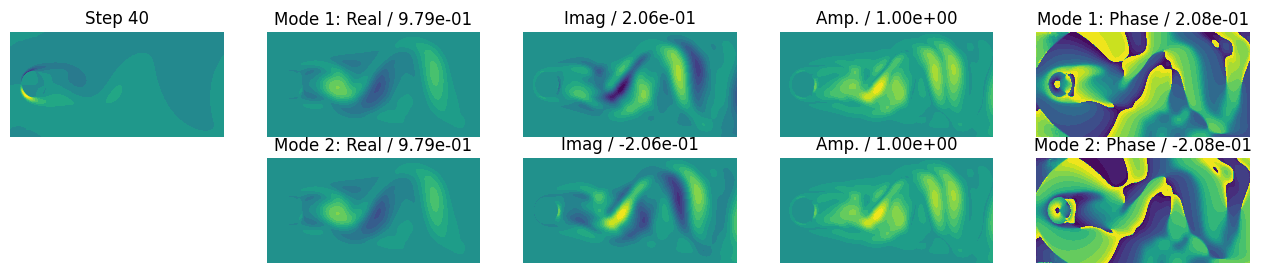

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16,3))
contour_fig(40, fig, ax, 'mode', IDX=2);

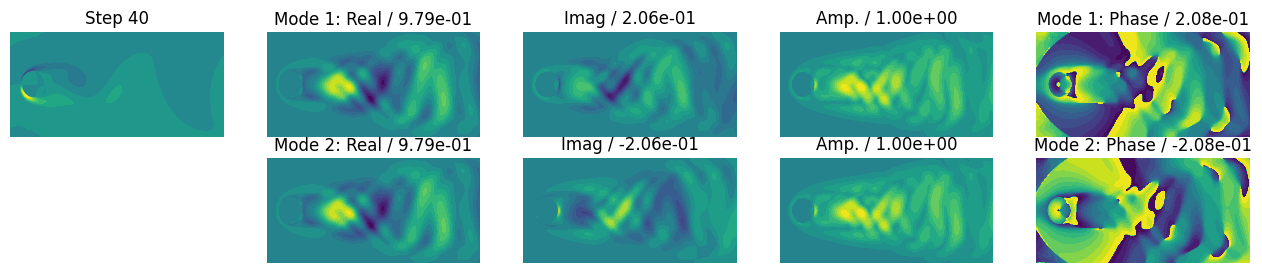

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16,3))
contour_fig(40, fig, ax, 'func', IDX=2);

Second, DT-DM with Diffusion Map.  This time the eigenmodes and eigenfunctions look identical, and both correlate closely to the rate of change in the flow field.

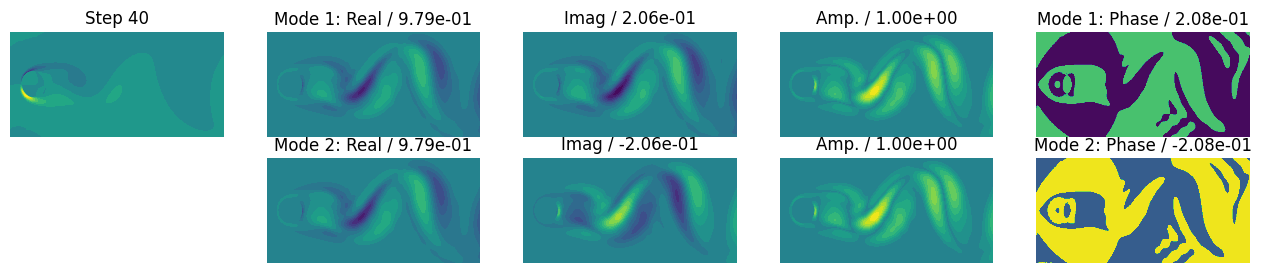

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16,3))
contour_fig(40, fig, ax, 'mode', IDX=3);

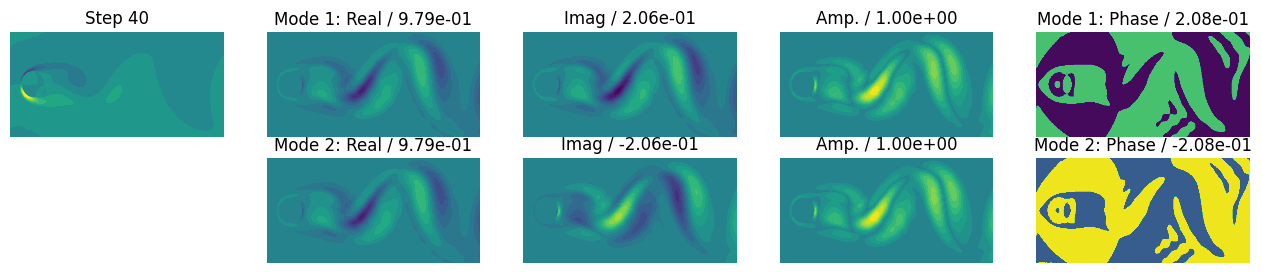

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16,3))
contour_fig(40, fig, ax, 'func', IDX=3);

Lastly, the plots can be animated as below.

Again, the output is not shown here to save storage, but feel free to try this locally.

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16,3))
setup_logging()
animate(lambda i: contour_fig(i, fig, ax, 'mode', IDX=2), filename=f"vis.mp4", fps=10, n_frames=len(t_grid))